# W266: TensorFlow Tutorial

We'll use TensorFlow for several models in the graded and ungraded work, and it will be particularly useful if you want to use neural networks for your course project.

This tutorial will teach similar material to those on the [TensorFlow website](https://www.tensorflow.org/), but with simpler data and using the Notebook format.

You might want to take a look at the standard tutorials anyway:

- [MNIST for ML Beginners](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/index.html)
- [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/index.html) (recommended)

If you haven't installed TensorFlow yet, follow the instructions in the  [**Course Set-Up**](Course%20Set-Up.ipynb) notebook.

In [1]:
import time
import random
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Generate data

We'll start by generating some toy data from a pair of gaussians:

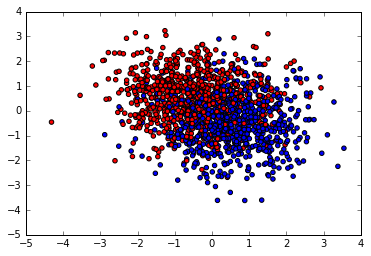

In [21]:
np.random.seed(1)
for factor in range (1,9):
    x0 = np.random.randn(100, 2) + 0.1 * factor *np.array([1, -1])
    x1 = np.random.randn(100, 2) + 0.1 * factor *np.array([-1, 1])
    X = np.vstack([x0, x1])
    y = np.concatenate([np.zeros(100), np.ones(100)])
    #print X, '\n', y
    # Randomly shuffle the data
    shuf_idx = np.random.permutation(len(y))
    X = X[shuf_idx]
    y = y[shuf_idx]
    #print X, '\n', y
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')

## Model: Linear Classifier

As a simple model, we'll just use logistic regression:
$$ \hat{y}_i = \sigma(w^Tx_i + b) $$

Or, in matrix form:
$$ \hat{y} = \sigma(X w + b) $$

As a quick-and-dirty baseline, we'll spin up a scikit-learn model.

In [ ]:
#pip install sklearn
import sklearn.linear_model

# Model parameters
lreg = 0.00001        # Regularization strength
params = dict(penalty='l2', C=(1.0/lreg)/len(y))
classifier = sklearn.linear_model.LogisticRegression(**params)
classifier.fit(X, y)

y_pred = classifier.predict_proba(X)[:,1]

def celoss(y_true, y_pred):
    """Compute cross-entropy loss."""
    return (y_true * -np.log(y_pred) + 
            (1 - y_true) * -np.log(1 - y_pred))

print "Accuracy: %.03f" % np.mean(y == (y_pred >= 0.5))
print "Mean cross-entropy loss: %.03f" % np.mean(celoss(y, y_pred))

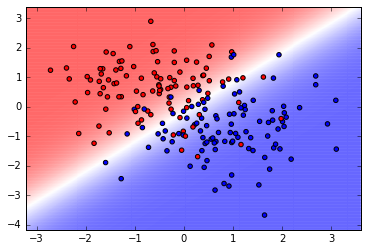

In [36]:
def plot_model(X, y, predict_func):
    # Plot model confidences over the region
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_sample = np.array([xx.ravel(), yy.ravel()]).T
    Z = predict_func(X_sample).reshape(xx.shape)
    
    # Rescale color levels to make plot easier to read
    zc = (Z - 0.5)*0.6 + 0.5
    plt.pcolormesh(xx, yy, zc, cmap='bwr', alpha=0.5, vmin=0, vmax=1)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
plot_model(X, y, lambda X: classifier.predict_proba(X)[:,1])

## TensorFlow Model

Constructing the TensorFlow model will be a bit more involved, as TensorFlow is a bit different from the procedural programming we're used to. We'll give a very quick introduction here, but you may want to refer to the [official TensorFlow "Getting Started" page](https://www.tensorflow.org/versions/r0.10/get_started/index.html) for more detail.

### Declarative Numerical Programming

The TensorFlow programming model has two phases: **graph construction** and **execution**.

In the **graph construction** phase, we operate on everything symbolically. Executing the Python code doesn't actually do any numerical calculations - it just tells TensorFlow how to do the computation later. Every variable you define here is a **Tensor**, which creates a node in the computation graph.

In the execution phase, we give TensorFlow input data and a list of output operations. It runs the data through the graph and returns numerical results as NumPy arrays.

#### Tensor Objects

Tensor objects are the symbolic equivalent of Numpy's `ndarray`, and support many similar operations. For example:
```
# w, v are np.array
y = np.dot(v, w) + b
```
Would be expressed as:
```
# w, v, b are tf.Tensor
y = tf.matmul(v, w) + b
```

There are a few ways to define Tensors, but the most important are:

- **[Constants and sequences](https://www.tensorflow.org/versions/r0.10/api_docs/python/constant_op.html#constants-sequences-and-random-values)**, like tf.constant(), tf.zeros(), or tf.linspace(). These create a Tensor with a fixed value, and pretty much work like their NumPy equivalents.

- **[Variables](https://www.tensorflow.org/versions/r0.10/how_tos/variables/index.html)**, which are persistent and can be modified during execution. Think model parameters, which get updated by training.

- **[Placeholders](https://www.tensorflow.org/versions/r0.10/api_docs/python/io_ops.html#placeholder)**, which are used for data inputs. You feed these in by passing a NumPy array at execution time.

Operations on tensors - like `tf.matmul()` or `tf.nn.softmax()` - produce other tensors and add additional nodes to the graph.

## Building the Logistic Regression Graph

We'll wire up a computation graph below with all the components of a logistic regression model. We need to define several tensors:

- `X_` : (batch_size, input_dim)
- `y_` : (batch_size), scalar {0,1}
- `w_` : (input_dim, 1)
- `b_` : scalar
- `logit_` : scalar, represents $X w + b$
- `pred_proba_` : scalar, represents $\hat{y} = \sigma(X w + b)$
- `loss_` : cross-entropy loss $CE(y,\hat{y}) = -y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})$

For this demo, we'll end all tensor names with underscores so they don't get confused with normal variables. In more complex code, you'll typically define a class instead and keep the tensors as member variables.

We'll also instrument the graph a bit with variable names. You don't need to do this, but it makes debugging a lot easier down the line.

In [37]:
import tensorflow as tf
tf.reset_default_graph()  # clear away any leftovers from previous executions

input_dim = X.shape[1]

# Placeholders for input matrix and target value.
# We pass "None" as the first shape argument; 
# this allows it to be dynamically computed later.
X_ = tf.placeholder(tf.float32, shape=[None, input_dim], name="X")
y_ = tf.placeholder(tf.float32, shape=[None], name="y")

# Variables for the parameters of our model
with tf.name_scope('model_parameters'):
    #w_ = tf.Variable(tf.zeros([input_dim, 1], dtype=tf.float32), name="w")
    w_ = tf.Variable(tf.zeros([input_dim, 1]), name="w")
    #b_ = tf.Variable(0.0, dtype=tf.float32, name="b")
    b_ = tf.Variable(0.0, name="b")

# Output layer: \sigma(Xw + b)
with tf.name_scope('logit'):
    logits_ = tf.squeeze(tf.matmul(X_, w_)) + b_
with tf.name_scope('pred_proba'):
    pred_proba_ = tf.sigmoid(logits_)

# Cost function
with tf.name_scope('cost_function'):
    loss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits_, y_, name='loss')

Finally, we also add two special ops:

- `init` : initializes model variables (w,b) to default values
- `train_step` : uses `tf.train.GradientDescentOptimizer` to tune weights

Note that we can specify the gradient descent code in just two lines! That's because TensorFlow includes *automatic differentiation* over the computation graph. It can automatically compute gradients with respect to our loss function, and the `GradientDescentOptimizer` class hides all the complexity of this from the user.

In [38]:
# Gradient descent training
with tf.name_scope('training'):
    alpha_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.GradientDescentOptimizer(alpha_)
    train_step_ = optimizer_.minimize(loss_)

# Initializer step
init_ = tf.initialize_all_variables()

## Training Our Model

Now it's execution time!

We need to run everything within a TensorFlow `Session`, which dispatches the actual computation and manages the state of Variables. Within that context, we can call:
```
    c, p, _ = session.run([cost, pred_proba, train_step],
                           feed_dict={X_: X,
                                      y_: Y})
```
in order to run a training step on the whole dataset. Note the feed dict: this is how you pass data into a TensorFlow graph. The dict keys are the _actual tensor variables_, and we map them to numpy arrays of compatible shape. 

Here, the tensor `X_` has shape `[None, input_dim]`, and `X` is a 2D array of shape `(num_points, input_dim)`, which is compatible. `Y` needs to have shape `(num_points,)`, or we'll get a runtime error when TensorFlow tries to compute the loss function.

`session.run` will evaluate and return the numerical values of each tensor as numpy arrays. For special operations like `train_step_`, it will also modify the values of Variables - in this case, by applying gradient descent:

$$ w \to w - \alpha \cdot \nabla_w\mathcal{L}(X; w, b) $$
$$ b \to b - \alpha \cdot \nabla_b\mathcal{L}(X; w, b) $$

For simplicity, we won't do any convergence tests during training: we'll just train for a fixed number of steps.

[iter 0] Average cost: 0.693
[iter 20] Average cost: 0.609
[iter 40] Average cost: 0.551
[iter 60] Average cost: 0.509
[iter 80] Average cost: 0.478
[iter 100] Average cost: 0.454
[iter 120] Average cost: 0.436
[iter 140] Average cost: 0.421
[iter 160] Average cost: 0.409
[iter 180] Average cost: 0.399
Training completed in 0.11 s

Accuracy: 0.880
Mean cross-entropy loss: 0.391


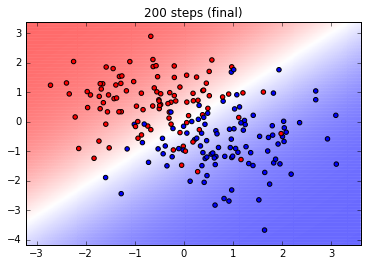

In [39]:
max_steps = 200
print_every = max_steps / 10
alpha = 0.0001  # learning rate

# We'll constrain this to run on CPU, as GPUs aren't very efficient
# on a model this small.
session = tf.Session(config=tf.ConfigProto(device_filters="/cpu:0"))
session.run(init_)  # initialize variables for this session

t0 = time.time()
for i in xrange(max_steps):          
    # Run a single gradient descent step
    c, p, _ = session.run([loss_, pred_proba_, train_step_],
                           feed_dict={X_: X, y_: y, alpha_: alpha})
        
    if (i % print_every == 0):
        avg_cost = sum(c) / len(y)
        print "[iter %d] Average cost: %.03f" % (i, avg_cost)
        
print "Training completed in %.02f s" % (time.time() - t0)
    
# Run model over training set one last time
costs, y_pred = session.run([loss_, pred_proba_], 
                            feed_dict={X_: X, y_: y})

print ""
print "Accuracy: %.03f" % np.mean(y == (y_pred >= 0.5))
print "Mean cross-entropy loss: %.03f" % np.mean(costs)

fig = plt.figure()
plot_model(X, y, lambda X: session.run(pred_proba_, feed_dict={X_:X}))
plt.title("%d steps (final)" % max_steps)

## Visualizing SGD progress

Here's a slightly fancier version, which will give you a "filmstrip" plot of your model training:

[iter 0] Average cost: 0.693  Accuracy: 0.500
[iter 20] Average cost: 0.609  Accuracy: 0.880
[iter 40] Average cost: 0.551  Accuracy: 0.875
[iter 60] Average cost: 0.509  Accuracy: 0.875
[iter 80] Average cost: 0.478  Accuracy: 0.875
[iter 100] Average cost: 0.454  Accuracy: 0.875
[iter 120] Average cost: 0.436  Accuracy: 0.875
[iter 140] Average cost: 0.421  Accuracy: 0.880
[iter 160] Average cost: 0.409  Accuracy: 0.880
[iter 180] Average cost: 0.399  Accuracy: 0.880
Training completed in 0.69 s

Accuracy: 0.880
Mean cross-entropy loss: 0.391


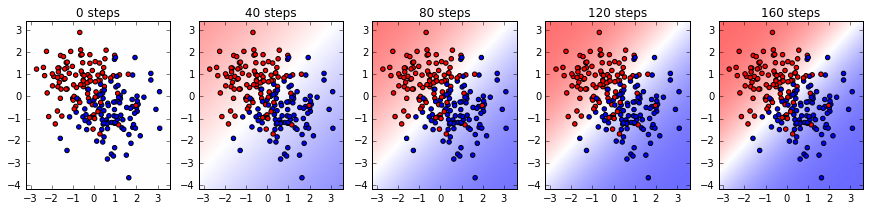

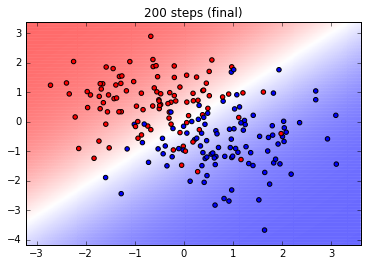

In [40]:
max_steps = 200
plot_every = max_steps / 5
print_every = max_steps / 10
alpha = 0.0001  # learning rate

session = tf.Session(config=tf.ConfigProto(device_filters="/cpu:0"))
session.run(init_)  # initialize variables for this session

# Subplot grid for model progress
ncols = (max_steps / plot_every)
fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(3*ncols, 3))
ctr = 0

t0 = time.time()
for i in xrange(max_steps):
    if (i % plot_every == 0) and (ctr < len(axs)):
        plt.sca(axs[ctr])
        plot_model(X, y, lambda X: session.run(pred_proba_, feed_dict={X_:X}))
        y_pred = session.run(pred_proba_, feed_dict={X_:X})
        plt.title("%d steps" % i)
        ctr += 1
                                
    # Run a single gradient descent step
    c, y_pred, _ = session.run([loss_, pred_proba_, train_step_],
                           feed_dict={X_: X, y_: y, alpha_: alpha})
        
    if (i % print_every == 0):
        avg_cost = sum(c) / len(y)
        print "[iter %d] Average cost: %.03f" % (i, avg_cost), 
        print " Accuracy: %.03f" % np.mean(y == (y_pred >= 0.5))
        
print "Training completed in %.02f s" % (time.time() - t0)
    
# Run model over training set one last time
costs, y_pred = session.run([loss_, pred_proba_], 
                            feed_dict={X_: X, y_: y})

print ""
print "Accuracy: %.03f" % np.mean(y == (y_pred >= 0.5))
print "Mean cross-entropy loss: %.03f" % np.mean(costs)

fig = plt.figure()
plot_model(X, y, lambda X: session.run(pred_proba_, feed_dict={X_:X}))
plt.title("%d steps (final)" % max_steps)

## Minibatch training

In general, we don't want to do a full gradient descent step each time - computing it over the entire dataset would be very expensive. However, the other extreme, single-example SGD, is also fairly inefficient: particularly when training on a GPU, there's a lot of overhead each time call `session.run(...)` with new data.

As a middle ground, it's standard practice to use _minibatches_. Essentially, we do SGD, but feed in a group (10-100) examples at a time. In fact, most TensorFlow functions are designed around this: typically, they expect the first dimension of the input tensor to be the batch size.

We can run a minibatch step exactly as above, just sampling data indices and passing in a slice to the `feed_dict`:
```
    idxs = np.random.randint(0, len(y), size=batch_size)
    c, p, _ = session.run([cost, pred_proba, train_step],
                           feed_dict={X_: X[idxs],
                                      y_: Y[idxs]})
```

For simplicity, we'll use a _bootstrap sample_, picking each minibatch as a random sample of indices. For memory layout reasons, it's more efficient to sample contiguous blocks; we'll leave that as an (ungraded) exercise.

[iter 100] Average cost (last 1000): 0.404
[iter 200] Average cost (last 1000): 0.312
[iter 300] Average cost (last 1000): 0.297
[iter 400] Average cost (last 1000): 0.338
[iter 500] Average cost (last 1000): 0.340
[iter 600] Average cost (last 1000): 0.324
[iter 700] Average cost (last 1000): 0.318
[iter 800] Average cost (last 1000): 0.325
[iter 900] Average cost (last 1000): 0.338
Training completed in 0.52 s

Accuracy: 0.855
Mean cross-entropy loss: 0.324


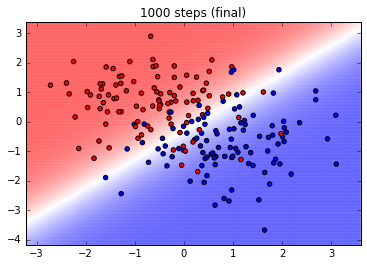

In [41]:
max_steps = 1000
batch_size = 10
print_every = max_steps / 10
alpha = 0.01  # learning rate

np.random.seed(12)

# We'll constrain this to run on CPU, as GPUs aren't very efficient
# on a model this small.
session = tf.Session(config=tf.ConfigProto(device_filters="/cpu:0"))
session.run(init_)  # initialize variables for this session

last_k_cost = 0.0
t0 = time.time()
for i in xrange(max_steps):
    # Print the average loss over the last few examples.
    # We'll do this intea
    if (i % print_every == 0) and (i > 0):
        avg_cost = last_k_cost / (print_every * batch_size)
        print "[iter %d] Average cost (last %d): %.03f" % (i, print_every * batch_size, 
                                                           avg_cost)
        last_k_cost = 0.0
    
    # Sample a training example
    idxs = np.random.randint(0, len(y), size=batch_size)
    # Run a single SGD step
    c, p, _ = session.run([loss_, pred_proba_, train_step_],
                           feed_dict={X_: X[idxs],
                                      y_: y[idxs], 
                                      alpha_: alpha})
    last_k_cost += sum(c)
print "Training completed in %.02f s" % (time.time() - t0)
    
# Run model over training set
costs, y_pred = session.run([loss_, pred_proba_], 
                            feed_dict={X_: X, y_: y})

print ""
print "Accuracy: %.03f" % np.mean(y == (y_pred >= 0.5))
print "Mean cross-entropy loss: %.03f" % np.mean(costs)

fig = plt.figure()
plot_model(X, y, lambda X: session.run(pred_proba_, feed_dict={X_:X}))
plt.title("%d steps (final)" % max_steps)

You'll notice that training is quite fast, but still slower than the scikit-learn model. For logistic regression, this is expected: the scikit-learn model is highly optimized, while we're using a very naive implementation here.

The TensorFlow model was also a bit more verbose than we might have hoped - although it did save us from taking derivatives by hand. While there's a certain amount of overhead for simple models like logistic regression, the TensorFlow model can be easily extended - for example, by adding more layers, or adapting it into a recurrent or convolutional neural network.

## TensorBoard: Visualizing Models

TensorFlow graphs can get to be quite complicated, but there's a handy utility, 
[TensorBoard](https://www.tensorflow.org/versions/r0.10/how_tos/summaries_and_tensorboard/index.html) that makes it easy to visualize their structure. It also serves as a dashboard interface that lets you view summary statistics, such as training loss over time. 

For now, we'll just use use the graph functionality. We need to output the graph to a summary directory, using the following line:

In [42]:
summary_writer = tf.train.SummaryWriter("tf_summaries", session.graph)

AttributeError: 'Graph' object has no attribute 'SerializeToString'

In [ ]:
!tensorboard --logdir="~/w266/week1/tf_summaries" --port 6006


Starting TensorBoard 29 on port 6006
(You can navigate to http://172.17.0.2:6006)


Now in a separate terminal, run:
```
tensorboard --logdir="~/w266/week1/tf_summaries" --port 6006
```

It'll bring up a web server similar to IPython/Jupyter, and you can see the graphs by going to http://localhost:6006/#graphs.

For the model above, you should see something similar to this:
![TensorBoard graph](logistic.graph.png)
You can click on nodes to expand them and see more detail - for example, try expanding `cost_function/cost` to see how the cross-entropy loss is implemented.